In [1]:
import os
import sys
BACKTESTER_DIR = os.path.realpath(os.path.join(os.getcwd(), '..', '..'))
DATA_DIR = os.path.join(BACKTESTER_DIR, 'data')
OPTIONS_DATA = os.path.join(DATA_DIR, 'SPX_2017.csv')
STOCKS_DATA = os.path.join(DATA_DIR, 'portfolio_data_2017.csv')
sys.path.append(BACKTESTER_DIR) # Add backtester base dir to $PYTHONPATH

In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt

from backtester import Backtest
from backtester.strategy import Strategy, StrategyLeg
from backtester.enums import Type, Direction, Stock
from backtester.datahandler import HistoricalOptionsData, TiingoData, Schema
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

As an example, we run a 2017 backtest of a portfolio consisting of a 97% allocation in stocks and 3% in options. The backtest will run for the time period spanned by the data, performing periodic rebalances with a user given frequency. 

Stock data is taken from [Tiingo](https://api.tiingo.com).

In [ ]:
%env TIINGO_API_KEY=your_tiingo_api_key

In [ ]:
api_key = os.environ["TIINGO_API_KEY"]

start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 12, 31)
tickers = ["VOO", "TUR", "RSX", "EWY", "EWS", "VTIP", "TLT", "BWX", "PDBC", "IAU", "VNQI"]

symbols = pdr.get_data_tiingo(tickers, api_key=api_key, start=start, end=end)

In [ ]:
save_path = os.path.join(DATA_DIR, 'portfolio_data_2017.csv')
symbols.to_csv(save_path)

Use *TiingoData* to load your stocks csv. Data must include `date`, `adjClose` and `symbol` columns to work.

In [4]:
stock_data = TiingoData(STOCKS_DATA)

In [5]:
stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,VOO,2017-01-03,206.74,207.33,205.560,206.68,4750181,194.997818,195.554308,193.884838,194.941226,4750181,0.0,1.0
1,VOO,2017-01-04,207.96,208.18,207.120,207.20,4622614,196.148526,196.356030,195.356235,195.431691,4622614,0.0,1.0
2,VOO,2017-01-05,207.80,208.04,207.013,207.75,2772065,195.997613,196.223982,195.255312,195.950453,2772065,0.0,1.0
3,VOO,2017-01-06,208.61,209.09,207.400,207.99,2194576,196.761608,197.214345,195.620332,196.176822,2194576,0.0,1.0
4,VOO,2017-01-09,207.95,208.48,207.885,208.34,1705181,196.139094,196.638991,196.077785,196.506943,1705181,0.0,1.0


To create a stock portfolio, use `Stock` as Stock(*name*, *percentage*), where *name* should match the name given in the `symbol` column and *percentage* is the percentage (from 0 to 1) allocated to that specific asset. Afterwards, store them in a list.

In [6]:
VOO = Stock('VOO', 0.1)
TUR = Stock('TUR', 0.05)
RSX = Stock('RSX', 0.05)
EWY = Stock('EWY', 0.05)
EWS = Stock('EWS', 0.05)
VTIP = Stock('VTIP', 0.10)
TLT = Stock('TLT', 0.20)
BWX = Stock('BWX', 0.10)
PDBC = Stock('PDBC', 0.05)
IAU = Stock('IAU', 0.15)
VNQI = Stock('VNQI', 0.10)

Make sure the sum of the percentages is 1.

In [7]:
0.10 + 0.05 + 0.05 + 0.05 + 0.05 + 0.10 + 0.20 + 0.10 + 0.05 + 0.15 + 0.10

1.0000000000000002

In [8]:
stocks = [
    VOO,
    TUR,
    RSX,
    EWY,
    EWS,
    VTIP,
    TLT,
    BWX,
    PDBC,
    IAU,
    VNQI
]

To load your options data, use `HistoricalOptionsData`. Both this and `Stock` make use of an underlying `schema` to map the expected column names to the ones in your data. *Schema.stocks()* and *Schema.options()* will return the default mappings (i.e, the ones that don't change anything). If you need to change some values in them use *update* like so:

In [9]:
options_schema = Schema.options()
options_schema.update({
            'contract': 'optionroot',
            'date': 'quotedate'})

Schema([Field(name='underlying', mapping='underlying'), Field(name='underlying_last', mapping='underlying_last'), Field(name='date', mapping='quotedate'), Field(name='contract', mapping='optionroot'), Field(name='type', mapping='type'), Field(name='expiration', mapping='expiration'), Field(name='strike', mapping='strike'), Field(name='bid', mapping='bid'), Field(name='ask', mapping='ask'), Field(name='volume', mapping='volume'), Field(name='open_interest', mapping='open_interest')])

In the last cell we updated the schema so that the *contract* and *date* columns are mapped to *optionroot* and *quotedate*, as they are in our data. This isn't needed in our case, since the default schema used by the backtester already uses this mapping; in general though, to use a custom schema pass it to `Stock` or `HistoricalOptionsData` when loading the csv (*schema=None* uses the default schema).

In [10]:
options_data = HistoricalOptionsData(OPTIONS_DATA, schema=None)
schema = options_data.schema

In [11]:
options_data.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,...,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,dte
0,SPX,2257.83,*,SPX170120C00100000,NaN,call,2017-01-20,2017-01-03,100,2161.50,...,2158.7,0,5615,0.1214,1.0,0.0,-1.0239,0.0,SPX170120C00100000,17
1,SPX,2257.83,*,SPX170120C00200000,NaN,call,2017-01-20,2017-01-03,200,2060.95,...,2058.8,0,6355,0.1214,1.0,0.0,-2.0479,0.0,SPX170120C00200000,17
2,SPX,2257.83,*,SPX170120C00300000,NaN,call,2017-01-20,2017-01-03,300,1960.45,...,1958.8,0,2000,0.1214,1.0,0.0,-3.0718,0.0,SPX170120C00300000,17
3,SPX,2257.83,*,SPX170120C00400000,NaN,call,2017-01-20,2017-01-03,400,1760.55,...,1858.9,0,25,0.1214,1.0,0.0,-4.0957,0.0,SPX170120C00400000,17
4,SPX,2257.83,*,SPX170120C00500000,NaN,call,2017-01-20,2017-01-03,500,1749.33,...,1758.9,0,3813,0.1214,1.0,0.0,-5.1197,0.0,SPX170120C00500000,17


For the options part of the backtest, we create a `Strategy` to determine when to enter on certain contracts. Remember to pass the options schema when creating it.

In [12]:
long_straddle = Strategy(schema)

Each strategy consists of one or more legs created with `StrategyLeg`. A leg consists of a type of contract (*put* or *call*) and a direction to enter (*buy* or *sell*). Our long straddle will have two legs, which will buy a call and a put respectively.

In [13]:
leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)

Legs have entry and exit filters, to determine the conditions a contract from that leg has to satisfy to select it for entry/exit. Filters are created with the following syntax, using the options schema to refer to column names (such as `underlying`, `dte` or `strike`).

In [14]:
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 31) & (schema.dte <= 60) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 60)
leg2.exit_filter = (schema.dte <= 60)

long_straddle.add_legs([leg1, leg2]);

In this case, the first leg will look for contracts with *SPX* as the underlying which have between 31 and 60 days to expiration (*dte*) and are at the money (*ATM*), i.e, their strike price is close to their spot. After entering, the exit filter will exit contracts having 60 or less *dte*, which for this given strategy means we will always exit contracts. This effectively means we are buying ATM put and call contracts, keeping them for a month and then selling them.

To put it all together, create a `Backtest` object and pass it a map specifying the percentage allocated to stocks, options and cash. Then set the stock portfolio, the options strategy and the data and run it.

In [15]:
bt = Backtest({'stocks': 0.97, 'options': 0.03, 'cash': 0})
bt.stocks = stocks
bt.options_strategy = long_straddle
bt.options_data = options_data
bt.stocks_data = stock_data

The *run* method takes the initial capital (default value *1.000.000*) and `rebalance_freq` as arguments. This last one defines how often, in months, a rebalancing of the portfolio is made, so that a value of 1 means a monthly rebalancing and 6 a bi-annual one. Its value defaults to 0, meaning no rebalancing done.

In [16]:
bt.run(rebalance_freq=1)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


leg_1                                                         \
              contract underlying expiration  type strike     cost      order   
0   SPX170217C02150000        SPX 2017-02-17  call   2150  11800.0  Order.BTO   
1   SPX170217C02150000        SPX 2017-02-17  call   2150 -12740.0  Order.STC   
2   SPX170317C02170000        SPX 2017-03-17  call   2170  11660.0  Order.BTO   
3   SPX170317C02170000        SPX 2017-03-17  call   2170 -22360.0  Order.STC   
4   SPX170421C02280000        SPX 2017-04-21  call   2280  12610.0  Order.BTO   
5   SPX170421C02280000        SPX 2017-04-21  call   2280  -8120.0  Order.STC   
6   SPX170519C02245000        SPX 2017-05-19  call   2245  12420.0  Order.BTO   
7   SPX170519C02245000        SPX 2017-05-19  call   2245 -14080.0  Order.STC   
8   SPX170616C02270000        SPX 2017-06-16  call   2270  12470.0  Order.BTO   
9   SPX170616C02270000        SPX 2017-06-16  call   2270 -15690.0  Order.STC   
10  SPX170721C02310000        SPX 2017-07-21  call   2310  12970.0  Order.BTO   
11  SPX170721C02310000        SPX 2017-07-21  call   2310 -11650.0  Order.STC   
12  SPX170818C02310000        SPX 2017-08-18  call   2310  12590.0  Order.BTO   
13  SPX170818C02310000        SPX 2017-08-18  call   2310 -16190.0  Order.STC   
14  SPX170915C02355000        SPX 2017-09-15  call   2355  12700.0  Order.BTO   
15  SPX170915C02355000        SPX 2017-09-15  call   2355 -11830.0  Order.STC   
16  SPX171020C02355000        SPX 2017-10-20  call   2355  13230.0  Order.BTO   
17  SPX171020C02355000        SPX 2017-10-20  call   2355 -17230.0  Order.STC   
18  SPX171117C02405000        SPX 2017-11-17  call   2405  13220.0  Order.BTO   
19  SPX171117C02405000        SPX 2017-11-17  call   2405 -16950.0  Order.STC   
20  SPX171215C02455000        SPX 2017-12-15  call   2455  13090.0  Order.BTO   
21  SPX171215C02455000        SPX 2017-12-15  call   2455 -18550.0  Order.STC   
22  SPX180119C02515000        SPX 2018-01-19  call   2515  14480.0  Order.BTO   

                 leg_2                                                       \
              contract underlying expiration type strike    cost      order   
0   SPX170217P02150000        SPX 2017-02-17  put   2150  1220.0  Order.BTO   
1   SPX170217P02150000        SPX 2017-02-17  put   2150  -160.0  Order.STC   
2   SPX170317P02170000        SPX 2017-03-17  put   2170  1010.0  Order.BTO   
3   SPX170317P02170000        SPX 2017-03-17  put   2170   -55.0  Order.STC   
4   SPX170421P02280000        SPX 2017-04-21  put   2280  1110.0  Order.BTO   
5   SPX170421P02280000        SPX 2017-04-21  put   2280  -285.0  Order.STC   
6   SPX170519P02245000        SPX 2017-05-19  put   2245  1040.0  Order.BTO   
7   SPX170519P02245000        SPX 2017-05-19  put   2245  -120.0  Order.STC   
8   SPX170616P02270000        SPX 2017-06-16  put   2270   820.0  Order.BTO   
9   SPX170616P02270000        SPX 2017-06-16  put   2270   -65.0  Order.STC   
10  SPX170721P02310000        SPX 2017-07-21  put   2310   860.0  Order.BTO   
11  SPX170721P02310000        SPX 2017-07-21  put   2310  -220.0  Order.STC   
12  SPX170818P02310000        SPX 2017-08-18  put   2310  1060.0  Order.BTO   
13  SPX170818P02310000        SPX 2017-08-18  put   2310  -120.0  Order.STC   
14  SPX170915P02355000        SPX 2017-09-15  put   2355   790.0  Order.BTO   
15  SPX170915P02355000        SPX 2017-09-15  put   2355  -100.0  Order.STC   
16  SPX171020P02355000        SPX 2017-10-20  put   2355  1020.0  Order.BTO   
17  SPX171020P02355000        SPX 2017-10-20  put   2355   -95.0  Order.STC   
18  SPX171117P02405000        SPX 2017-11-17  put   2405   780.0  Order.BTO   
19  SPX171117P02405000        SPX 2017-11-17  put   2405  -110.0  Order.STC   
20  SPX171215P02455000        SPX 2017-12-15  put   2455   850.0  Order.BTO   
21  SPX171215P02455000        SPX 2017-12-15  put   2455  -120.0  Order.STC   
22  SPX180119P02515000        SPX 2018-01-19  put   2515  1070.0  Order.BTO   

     totals    

When done, the backtester returns a trade log with all the option trades. There is also a balance sheet with daily returns, capital and other information for each stock symbol and options.

In [17]:
bt.balance

,total capital,cash,VOO,TUR,RSX,EWY,EWS,VTIP,TLT,BWX,...,IAU,VNQI,options qty,calls capital,puts capital,stocks qty,options capital,stocks capital,% change,accumulated return
2017-01-02,1.000000e+06,1000000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,NaN,NaN
2017-01-03,9.991600e+05,4252.203989,96913.915483,48486.088959,48493.996041,48485.711480,48496.962760,96970.393641,193897.445209,96996.896604,...,145492.92,96981.885738,2.0,22960.0,2240.0,34536.0,25200.0,9.697078e+05,-0.000840,0.999160
2017-01-04,1.005354e+06,4252.203989,97485.817277,48563.271527,48808.018217,48817.743929,49267.903052,97009.844574,194642.955279,97299.303141,...,146144.77,98265.641145,2.0,24600.0,1620.0,34536.0,26220.0,9.748815e+05,0.006199,1.005354
2017-01-05,1.013846e+06,4252.203989,97410.813763,48362.596851,48606.146819,49302.331828,50207.486533,97128.197374,197689.822522,98395.526836,...,148361.06,99432.691515,2.0,24380.0,1600.0,34536.0,25980.0,9.836141e+05,0.008447,1.013846
2017-01-06,1.010046e+06,4252.203989,97790.519052,47884.064932,48269.694487,48763.900829,49894.292040,96970.393641,195874.667569,97715.112129,...,147318.10,99335.437317,2.0,26020.0,1240.0,34536.0,27260.0,9.785336e+05,-0.003749,1.010046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1.172150e+06,4311.464660,114876.694450,62052.589006,57247.456248,55795.201266,56439.121909,112930.078174,223250.588763,111696.704128,...,168071.82,114300.129718,2.0,34780.0,500.0,36059.0,35280.0,1.132559e+06,0.002874,1.172150
2017-12-22,1.175638e+06,4311.464660,114853.445706,62409.383959,58044.851172,56275.993827,56351.551511,112884.385243,223555.184269,111934.694264,...,169037.75,115033.070138,2.0,34280.0,520.0,36059.0,34800.0,1.136527e+06,0.002976,1.175638
2017-12-26,1.178685e+06,4311.464660,114720.416392,62721.579544,58594.778705,56066.616421,56285.873712,113002.044540,224218.127430,111934.694264,...,170003.68,115206.661291,2.0,34160.0,470.0,36059.0,34630.0,1.139744e+06,0.002592,1.178685
2017-12-27,1.184637e+06,4311.464660,114785.826746,62587.781436,58292.318562,56904.126044,56504.799708,113048.432900,227138.660814,112410.674538,...,170831.62,116016.753334,2.0,34180.0,520.0,36059.0,34700.0,1.145626e+06,0.005050,1.184637


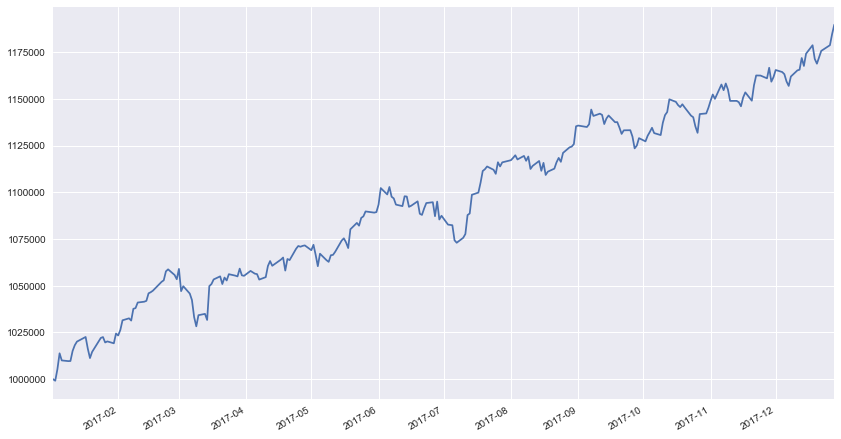

In [18]:
bt.balance['total capital'].plot();

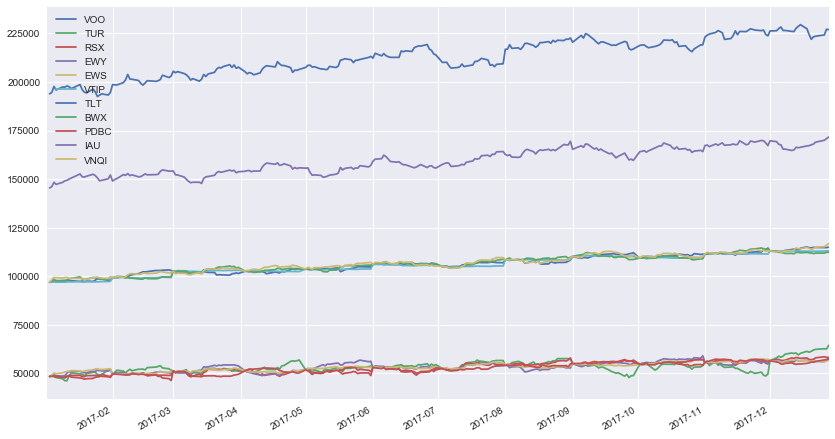

In [19]:
bt.balance[[stock.symbol for stock in stocks]].plot();

Pass the balance dataframe to 
the functions `returns_chart`, `returns_histogram` and `monthly_returns_heatmap` for better visualization. 

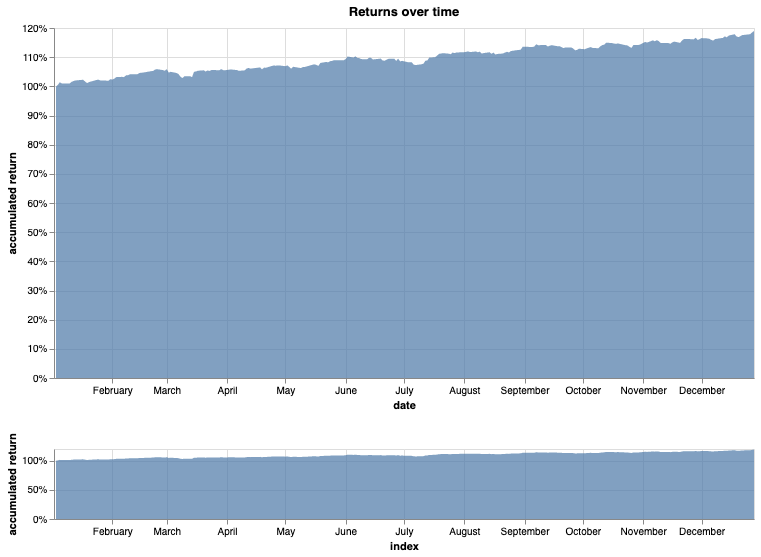

In [20]:
returns_chart(bt.balance)

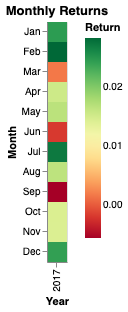

In [21]:
monthly_returns_heatmap(bt.balance)

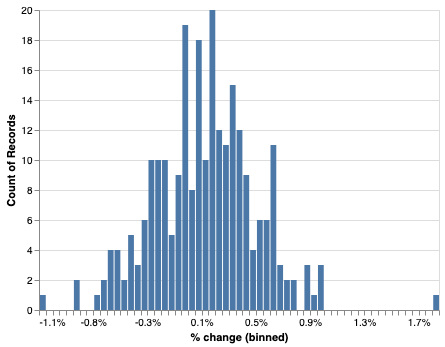

In [22]:
returns_histogram(bt.balance)

The backtest also supports an [sma](https://www.investopedia.com/terms/s/sma.asp) option. If the argument `sma_days` is passed to the `run` method with a value of n, on each rebalancing day the backtest will only buy shares of a stock symbol if its current price is above the sma of the last n days. To illustrate, we run the same backtest as before but with *sma_days = 30*.

In [23]:
bt.run(rebalance_freq=1, sma_days=30);

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


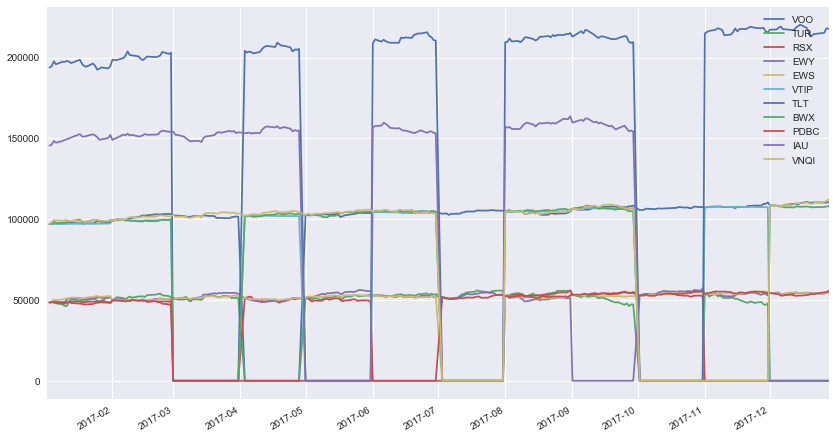

In [26]:
bt.balance[[stock.symbol for stock in stocks]].plot();

Notice how the capital held in certain symbols sometimes drops to zero, meaning on those months we did not buy shares of those symbols because their price was below the sma.

Finally, the daily returns column (`% change`) can be passed to the Quantopian library [pyfolio](https://github.com/quantopian/pyfolio) to obtain summary statistics and a few plots of the returns.

Start date,2017-01-03
End date,2017-12-28
Total months,11
,Backtest
Annual return,13.3%
Cumulative returns,13.2%
Annual volatility,4.9%
Sharpe ratio,2.59
Calmar ratio,5.99
Stability,0.92
Max drawdown,-2.2%


/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.22,2017-06-06,2017-07-06,2017-08-28,60
1,1.82,2017-09-07,2017-09-27,2017-10-27,37
2,1.80,2017-03-01,2017-03-09,2017-04-24,39
3,1.10,2017-01-17,2017-01-19,2017-01-31,11
4,0.98,2017-05-15,2017-05-18,2017-05-22,6


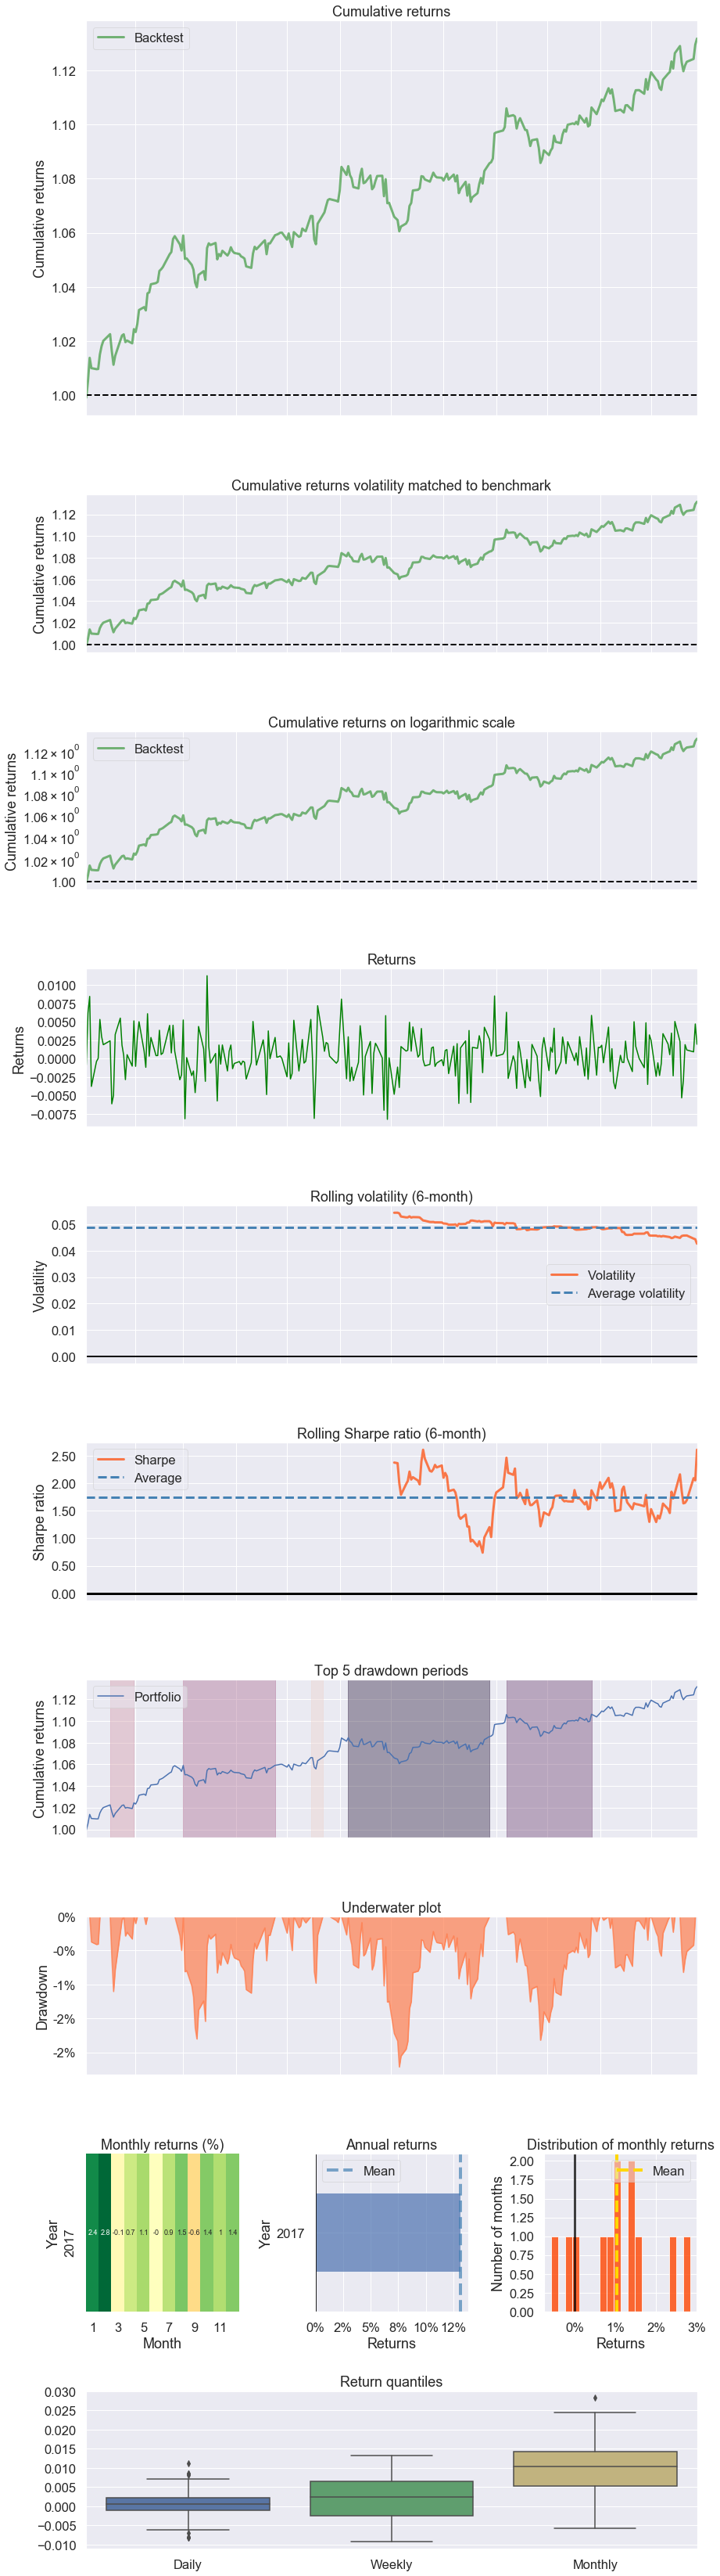

In [25]:
pf.create_returns_tear_sheet(returns =  bt.balance['% change'].dropna())